<a href="https://colab.research.google.com/github/ivangd97/denoising_autoencoder/blob/master/Autoencoder_bioinspirada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VERSIÓN DE KERAS
Importamos la librería y mostramos la versión

In [0]:
import keras
keras.__version__

'2.2.5'

# DISPOSITIVOS
Mostramos la lista de dispositivos a los que tenemos acceso

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6974396152517807144
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3503226719242473085
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12580239582809127559
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12125271998924373658
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# MÉTODO QUE CONVIERTE LA IMAGEN RGB A GRIS

He utilizado un método ya hecho de conversión de rgb a gris para utilizarlo a la hora de transformar las imágenes a gris con el fin de que el autoencoder las coloree.

Le entra una imagen rgb y devuelve una imagen en escala de grises con la siguiente cuenta:

salida = 0.299 * rojo(R) + 0.587 * verde(G) + 0.114 * azul(B)

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# DATASET Y REDIMENSIONAMIENTO
Descargaremos el dataset de cifar10 que se incluye en keras, a continuación redimensionaremos las imágenes y las normalizaremos entre 0 y 1.

Utilizaremos sólo train_images y test_images para el autoencoder.

In [0]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

(train_images, _), (test_images, _) = cifar10.load_data()

fila = train_images.shape[1]
columna = train_images.shape[2]
canal = train_images.shape[3]

print (train_images.shape)
train_images = train_images.reshape((50000, 32, 32, canal))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 32 , 32, canal))
test_images = test_images.astype('float32') / 255

print(test_images.shape)


170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# VISUALIZACIÓN DE TEST_IMAGES

Mostraremos las 100 primeras imágenes del vector de test que hemos cargado.

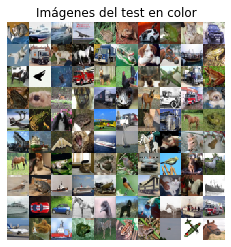

In [0]:
import numpy as np
import matplotlib.pyplot as plt

test_color = test_images[:100]
test_color = test_color.reshape((10, 10, fila, columna, canal))
test_color = np.vstack([np.hstack(i) for i in test_color])
plt.figure()
plt.axis('off')
plt.title('Imágenes del test en color')
plt.imshow(test_color, interpolation='none')
plt.show()

# OBTENCIÓN DE LAS IMÁGENES GRISES

Ahora pasamos a gris las imágenes del dataset

In [0]:
train_images_gray = rgb2gray(train_images)
test_images_gray = rgb2gray(test_images)

#Mostramos las dimensiones de los nuevos sets en gris
print(train_images_gray.shape)
print(test_images_gray.shape)

(50000, 32, 32)
(10000, 32, 32)


# VISUALIZACIÓN DE LAS IMÁGENES EN GRIS

Ahora comprobamos que se han pasado correctamente las imágenes a color gris.

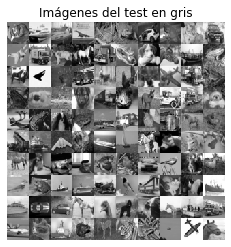

In [0]:
test_gris = test_images_gray[:100]
test_gris = test_gris.reshape((10, 10, fila, columna))
test_gris = np.vstack([np.hstack(i) for i in test_gris])
plt.figure()
plt.axis('off')
plt.title('Imágenes del test en gris')
plt.imshow(test_gris, interpolation='none', cmap='gray')
plt.show()

# NORMALIZACIÓN DE LOS VALORES DE TRAIN Y TEST EN GRIS

In [0]:
train_images_gray = train_images_gray.astype('float32') / 255
train_images_gray = train_images_gray.reshape(50000, 32, 32, 1)

test__images_gray = test_images_gray.astype('float32') / 255
test_images_gray = test_images_gray.reshape(10000, 32, 32, 1)

# QUÉ ES UN AUTOENCODER Y MODELO DE LA RED 

Un autoencoder es una red neuronal que tiene como objetivo la generación de nuevos datos comprimiendo en primer lugar la entrada a dicha red y luego descomprimiéndolos en base a la información que se ha obtenido. Podemos distinguir entonces las siguientes partes: 
- *Encoder* : En esta parte de la red se realizará la compresión de las imágenes.
- *Capas densas* : Se encargan de obtener la información que deseamos de la entrada comprimida por el encoder.
- *Decoder* : Reconstruye la entrada en base a la información adquirida en las capas previas.

La idea de un autoencoder es reconstruir la imagen de entrada habiendo aprendido algo durante el proceso, este aprendizaje lo conseguiremos imponiendo límites a la codificación, haciendo que el espacio generado sea de menor dimensión que la entrada, así obligaremos al autoencoder a obtener las características más relevantes de los datos de entrada. En caso de no imponer suficientes restricciones, la red simplemente comprimirá y descomprimirá la imagen sin haber obtenido ninguna información de ella.

Las aplicaciones actuales más relevantes que tienen los autoencoders son la reducción de ruido en las imágenes y la reducción de dimensionalidad en éstas para la visualización de datos.

Existen varios tipos de AutoEncoders, pero en este proyecto utilizaremos un AutoEncoder convolucional, en este tipo de AutoEncoders se obliga a la red a aprender desde una versión comprimida de la imagen de entrada (por ello las convoluciones) y no de un vector unidimensional.

Podemos observar la división de capas convolucionales con su correspondiente capa de *MaxPooling2D* posterior,las capas densas y, al final, la parte correspondiente al decoder que descomprime las imágenes. A continuación se explica un poco el funcionamiento de cada una de las capas utilizadas:

- *Conv2D* : Crea un núcleo de convolución con la capa de entrada para producir un tensor de salidas. Si el bias es 1, el vector de bias se crea y añade a la salida.
- *MaxPooling2D* : Una capa de maxpooling de (2,2) como tenemos abajo recorrerá las imágenes píxel por píxel pero en vez de tomar sólo uno, cogerá una ventana de 2x2 (4 píxeles).
- *Dense* : Son capas fully connected que se encuentran generalmente al final de la red y realizan la categorización.
- *UpSampling2D* :

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import models

#input_shape es el tamaño de cada dato del dataset (tamaño de la imagen)
#encoder
print(train_images.shape[1:])
input_img = (fila, columna, 1)
input_layer = Input(shape=input_img)
encoder = Conv2D(64, (3, 3), activation='relu', padding = 'same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding = 'same' )(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding = 'same' )(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

#dense layers
dense = Dense(100)(encoder)
dense = Dense(100)(dense)
dense = Dense(100)(dense)

#decoder
decoder = Conv2D(256, (3, 3), activation='relu', padding = 'same' )(dense)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(128, (3, 3), activation='relu', padding = 'same' )(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(64, (3, 3), activation='relu', padding = 'same' )(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(decoder)

autoencoder = models.Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print(train_images.shape[1:])


(32, 32, 3)
(32, 32, 3)


# ENTRENAMIENTO DE LA RED

Dado que el *data aumentation* no reportaba una tasa de aprendizaje en validación que subiese del 50%, se ha tratado de modificar los valores del *batch_size* pese a sufrir un tiempo de entrenamiento elevado (las pruebas con *batch_size* más alto y más épocas reportaban tasas en validación del 76/77%).

La ejecución del entrenamiento con *data aumentation* se encuentra comentada encima.

In [0]:
batch_size = 32
epochs = 100

history = autoencoder.fit(train_images_gray, train_images,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (test_images_gray, test_images),
          verbose = 1,
          shuffle = True
          )

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 52s 1ms/step - loss: 0.6905 - val_loss: 0.6914
Epoch 2/20
50000/50000 [==============================] - 50s 993us/step - loss: 0.6910 - val_loss: 0.6913
Epoch 3/20
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6910 - val_loss: 0.6913
Epoch 4/20
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6910 - val_loss: 0.6914
Epoch 5/20
50000/50000 [==============================] - 50s 993us/step - loss: 0.6910 - val_loss: 0.6913
Epoch 6/20
50000/50000 [==============================] - 49s 977us/step - loss: 0.6910 - val_loss: 0.6913
Epoch 7/20
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6910 - val_loss: 0.6913
Epoch 8/20
50000/50000 [==============================] - 50s 992us/step - loss: 0.6910 - val_loss: 0.6913
Epoch 9/20
50000/50000 [==============================] - 50s 1ms/step - loss: 0.6910 - val_loss: 0.69

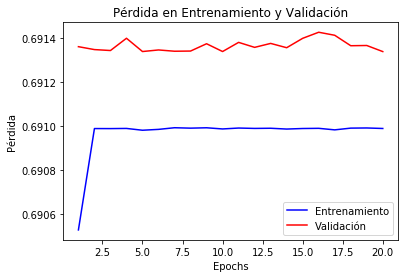

In [0]:
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(ent_loss) + 1)

plt.plot(epochs, ent_loss, 'b', label='Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [0]:
decoded_images = autoencoder.predict(test_images_gray)

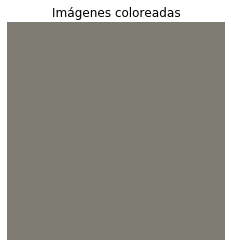

In [0]:
imgs = decoded_images[:100]
imgs = imgs.reshape((10, 10, fila, columna, canal))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Imágenes coloreadas')
plt.imshow(imgs, interpolation='none')
plt.show()